<a href="https://colab.research.google.com/github/xSakix/AI_colab_notebooks/blob/master/imdb_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB DNN

Lets do the IMDB dataset with a simple DNN. The first one is in numpy and second will be done in pytorch, but only using tensor for the GPU. Not using backwards or any NN functionality, as the goal is to implement it and learn how it works behind the scenes.

In [40]:
import keras
import numpy as np
import torch
import matplotlib.pyplot as plt


torch.manual_seed(2019)
np.random.seed(42)
EPS = torch.finfo(torch.float32).eps

In [41]:
def convert_to_array(x):
    x_temp = []

    for x in x_train:
        if len(x) < maxlen:
            for i in range(maxlen - len(x)):
                x.append(0.0)
        elif len(x) > maxlen:
            x = x[0:maxlen]

        x_temp.append(x)

    return np.array(x_temp)


def relu(z):
    other = torch.zeros(z.size()).cuda()
    return torch.maximum(other,z).cuda()


def back_relu(Z, dA):
    dZ = dA.detach().clone().cuda()  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    # normaly it would be:
    # Z[Z <= 0] = 0.
    # Z[Z > 0] = 1
    # dZ = dA*Z
    # so for short we have this
    dZ[Z <= 0.] = 0.
    # which says, that make dZ a copy od dA,then where Z <= 0 we have 0
    # and where Z > 0 we have 1*dA = dA
    return dZ


def sigmoid(z):
    return 1. / (1. + torch.exp(-z).cuda()+EPS)


def back_sigmoid(Z, dA):
    s = 1 / (1 + torch.exp(-Z).cuda()+EPS)
    dZ = dA * s * (1 - s)
    return dZ

In [42]:
x=torch.randn(1,5).cuda()
dx=torch.randn(1,5).cuda()
print(x)
print(relu(x))
print("*"*80)
print(x)
print(dx)
#where x <= 0 dx will 0
print(back_relu(x,dx))
print("*"*80)
print(sigmoid(x))
print(back_sigmoid(x,dx))


tensor([[-0.1187,  0.2110,  0.7463, -0.6136, -0.1186]], device='cuda:0')
tensor([[0.0000, 0.2110, 0.7463, 0.0000, 0.0000]], device='cuda:0')
********************************************************************************
tensor([[-0.1187,  0.2110,  0.7463, -0.6136, -0.1186]], device='cuda:0')
tensor([[1.5565, 1.3662, 1.0199, 2.4644, 1.1630]], device='cuda:0')
tensor([[0.0000, 1.3662, 1.0199, 0.0000, 0.0000]], device='cuda:0')
********************************************************************************
tensor([[0.4704, 0.5526, 0.6784, 0.3512, 0.4704]], device='cuda:0')
tensor([[0.3878, 0.3378, 0.2225, 0.5616, 0.2897]], device='cuda:0')


In [23]:
max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [24]:
x_train = convert_to_array(x_train)
x_val = convert_to_array(x_val)
y_train = y_train.reshape(y_train.shape[0], -1).T
y_val = y_val.reshape(y_val.shape[0], -1).T

x_train = x_train.reshape(x_train.shape[0], -1).T
x_val = x_val.reshape(x_val.shape[0], -1).T

print("*" * 80)
print("x_train:{}".format(x_train.shape))
print("x_val:{}".format(x_val.shape))
print("y_train:{}".format(y_train.shape))
print("y_val:{}".format(y_val.shape))
print("*" * 80)

assert (x_train.shape == (maxlen, 25000))
assert (y_train.shape == (1, 25000))
assert (x_val.shape == (maxlen, 25000))
assert (y_val.shape == (1, 25000))

print("*" * 80)

print("max x_train before:{}".format(np.max(x_train)))
print("max x_val before:{}".format(np.max(x_val)))
print("min before:{}, {}".format(np.min(x_train), np.min(x_val)))

# norm didn't work well
# norm = np.linalg.norm(x_train, ord=2)
# print("norm={}".format(norm))

# normalizing around max_features works well
# x_train = x_train / max_features
# x_val = x_val / max_features

# centering around mean
x_mean = np.mean(x_train)
x_std = np.std(x_train)
print("(mean,std)=({},{})".format(x_mean, x_std))
x_train = (x_train - x_mean) / x_std
x_val = (x_val - x_mean) / x_std

print("max x_train after norm:{}".format(np.max(x_train)))
print("max x_val after norm:{}".format(np.max(x_val)))
print("min after norm:{}, {}".format(np.min(x_train), np.min(x_val)))

# assert ((x_train >= 0.).all() and (x_train < 1.).all())

print("*" * 80)

print("y_train unique vals:{}".format(np.unique(y_train)))
print("y_val unique vals:{}".format(np.unique(y_train)))

print("*" * 80)

********************************************************************************
x_train:(200, 25000)
x_val:(200, 25000)
y_train:(1, 25000)
y_val:(1, 25000)
********************************************************************************
********************************************************************************
max x_train before:19999.0
max x_val before:19999.0
min before:0.0, 0.0
(mean,std)=(896.850569,2520.963839741494)
max x_train after norm:7.5773198845084515
max x_val after norm:7.5773198845084515
min after norm:-0.35575701438540475, -0.35575701438540475
********************************************************************************
y_train unique vals:[0 1]
y_val unique vals:[0 1]
********************************************************************************


In [49]:
# 2 layer network
m = x_train.shape[1]
n_x = x_train.shape[0]
n_h = 128
n_y = 1
# init params
W1 = torch.randn(n_h, n_x).cuda() * 0.01
b1 = torch.zeros((n_h, 1)).cuda()
W2 = torch.randn(n_y, n_h).cuda() * 0.01
b2 = torch.zeros((n_y, 1)).cuda()

assert (W1.size() == (n_h, n_x))
assert (b1.size() == (n_h, 1))
assert (W2.size() == (n_y, n_h))
assert (b2.size() == (n_y, 1))

In [50]:
costs = []
n_iter = 100000
learning_rate = 0.01

x_train = torch.tensor(x_train,dtype=torch.float32).cuda()
y_train = torch.tensor(y_train,dtype=torch.float32).cuda()

for i in range(0, n_iter):
    # forward
    # A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    # do a forward pass over relu
    # print("W1.shape:{}".format(W1.shape))
    # print("X.shape:{}".format(x_train.shape))
    # m x n * n x p = m x p
    # (5, 200) * (200, 25000)
    Z1 = torch.mm(W1, x_train).cuda() + b1
    assert (Z1.size() == (n_h, m))
    A1 = relu(Z1)
    assert (A1.size() == (n_h, m))
    # A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
    Z2 = torch.mm(W2, A1).cuda() + b2
    assert (Z2.size() == (n_y, m))
    A2 = sigmoid(Z2)
    assert (A2.size() == (n_y, m))

    # compute cost
    cost = -(1 / m) * torch.sum(y_train * torch.log(A2).cuda() + (1 - y_train) * torch.log(1 - A2).cuda()).cuda()
    cost = torch.squeeze(cost)
    # backward compute loss
    dA2 = -(torch.divide(y_train, A2).cuda() - torch.divide(1 - y_train, 1 - A2).cuda())
    # print("dA2.shape={}".format(dA2.shape))
    assert (dA2.size() == A2.size())
    # backward
    dZ2 = back_sigmoid(Z2, dA2)
    assert (dZ2.size() == dA2.size())

    dW2 = (1 / m) * torch.mm(dZ2, A1.T).cuda()
    db2 = (1 / m) * torch.sum(dZ2, dim=1, keepdims=True).cuda()
    dA1 = torch.mm(W2.T, dZ2).cuda()

    assert (dA1.size() == A1.size())
    assert (dW2.size() == W2.size())
    assert (db2.size() == b2.size())

    dZ1 = back_relu(Z1, dA1)
    assert (dZ1.size() == dA1.size())

    dW1 = (1 / m) * torch.mm(dZ1, x_train.T).cuda()
    db1 = (1 / m) * torch.sum(dZ1, dim=1, keepdims=True).cuda()
    assert (dW1.size() == W1.size())
    assert (db1.size() == b1.size())

    # update params
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    # print stats
    if i % 1000 == 0:
        print("Cost after iteration {}: {}".format(i, cost))
    if i % 1000 == 0:
        costs.append(cost)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Cost after iteration 0: 0.6931062340736389
Cost after iteration 1000: 0.6920350790023804
Cost after iteration 2000: 0.6901419162750244
Cost after iteration 3000: 0.6875673532485962
Cost after iteration 4000: 0.6852700710296631
Cost after iteration 5000: 0.6830765604972839
Cost after iteration 6000: 0.6806917190551758
Cost after iteration 7000: 0.6780092120170593
Cost after iteration 8000: 0.6750380396842957
Cost after iteration 9000: 0.6717337369918823
Cost after iteration 10000: 0.6679622530937195
Cost after iteration 11000: 0.6635579466819763
Cost after iteration 12000: 0.6583427786827087
Cost after iteration 13000: 0.6521320343017578
Cost after iteration 14000: 0.6447542309761047
Cost after iteration 15000: 0.6360668540000916
Cost after iteration 16000: 0.6259809136390686
Cost after iteration 17000: 0.6145573854446411
Cost after iteration 18000: 0.601876437664032
Cost after iteration 19000: 0.5880638957023621
Cost after iteration 20000: 0.5733454823493958
Cost after iteration 21000:

In [52]:
#predict
p = torch.zeros((1, x_train.shape[1])).cuda()
Z1 = torch.mm(W1, x_train).cuda() + b1
A1 = relu(Z1)
Z2 = torch.mm(W2, A1).cuda() + b2
A2 = sigmoid(Z2)

# convert probas to 0/1 predictions
for i in range(0, A2.shape[1]):
    if A2[0, i] > 0.5:
        p[0, i] = 1
    else:
        p[0, i] = 0

print("Accuracy on training set: " + str(torch.sum((p == y_train)/x_train.shape[1]).cuda()))

Accuracy: tensor(0.9840, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Accuracy on validation/test set: tensor(0.4967, device='cuda:0')


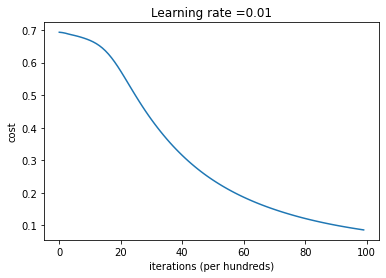

In [53]:
x_val = torch.tensor(x_val,dtype=torch.float32).cuda()
y_val = torch.tensor(y_val,dtype=torch.float32).cuda()


#predict
p = torch.zeros((1, x_val.shape[1])).cuda()
Z1 = torch.mm(W1, x_val).cuda() + b1
A1 = relu(Z1)
Z2 = torch.mm(W2, A1).cuda() + b2
A2 = sigmoid(Z2)

# convert probas to 0/1 predictions
for i in range(0, A2.shape[1]):
    if A2[0, i] > 0.5:
        p[0, i] = 1
    else:
        p[0, i] = 0

print("Accuracy on validation/test set: " + str(torch.sum((p == y_val)/x_val.shape[1]).cuda()))

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

# summary

So even with enough power(GPU) and kinda low loss/cost we actually don't get better accuracy on validation set. 

That looks like **overfitting**.
